Define Hyperparameters and Paths (Then You Can Just Run All of the Cells)

In [ ]:
WELLS = ["CCS1", "VW1"]             #wells considered by model
KFOLDS = 10                         #num learners for k-fold validation
FORMATIONS = [                      #formations considered in model (comment out ones you want to ignore)
    "Eau Claire",
    "Mt. Simon E",
    "Mt. Simon D",
    "Mt. Simon C",
    "Mt. Simon B",
    "Mt. Simon A",
    "Argenta",
    "Precambrian"
    ]


DATALOGS_PATH = "REU Project/Data/Raw CSV Files/raw_"
LABELS_PATH = "REU Project/Data/labels/label_"
MODEL_DUMP_PATH = "REU Project/Models/LogReg/"

Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, \
mean_absolute_error, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, cross_val_score, KFold, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from random import randint, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os
import seaborn
import joblib
import math

Retrieve Data and Labels

In [ ]:
datalogs = {}
labels = {}
datasets = {}
num_features = 0
for well in WELLS:
  datalogs_df = pd.read_csv(DATALOGS_PATH + well + ".csv")
  labels_df = pd.read_csv(LABELS_PATH + well + ".csv")

  #filter rock formations considered
  datalogs_df = datalogs_df[datalogs_df["FORM"].isin(FORMATIONS)]

  datalogs[well] = datalogs_df
  labels[well] = labels_df
  num_features = len(datalogs_df.columns) - 2 #exclude DEPT and FORM

  dataset = pd.merge(datalogs_df, labels_df, on='DEPT') #merge data and labels
  datasets[well] = dataset

  print(f"{well} : Shape of inputs= {datalogs_df.shape}")
  print(f"{well} : Shape of labels= {labels_df.shape}")
  print(f"{well} : Shape of merged= {dataset.shape}")

print(f"Num features: {num_features}")

CCS1 : Shape of inputs= (4217, 28)
CCS1 : Shape of labels= (4217, 2)
CCS1 : Shape of merged= (4217, 29)
VW1 : Shape of inputs= (3999, 28)
VW1 : Shape of labels= (3999, 2)
VW1 : Shape of merged= (3999, 29)
Num features: 26


Optional Data Preprocessing Tools (Comment out function calls in final cell if you don't want to use)

In [ ]:
def normalize(X_train, X_test):
  """
  Fit normalization to training data and apply to test data. Choose standard
  standard or MinMax Scaler.
  """
  scaler = StandardScaler()
  #scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

In [ ]:
def balance_dataset(dataset):
  """
  Undersample negative class to address bias in database. Adjust rat variable
  to change ratio of negative class to positive class data points.
  """
  df_0 = dataset[dataset['HAS_FRAC'] == 0]
  df_1 = dataset[dataset['HAS_FRAC'] == 1]

  # Randomly sample majority class so that it has rat times more data points
  # than minority class
  rat = 2
  min_samples = min(len(df_0), len(df_1))
  df_0_sampled = df_0.sample(n=min_samples * rat, replace=False)
  df_1_sampled = df_1.sample(n=min_samples, replace=False)

  # Concatenate the sampled DataFrames and shuffle
  balanced_df = pd.concat([df_0_sampled, df_1_sampled])
  balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
  return balanced_df

In [ ]:
def apply_PCA(X_train, X_test):
  """
  Returns components that explain n% of the data's variance. Adjust n variable
  to change what percentage of variance should be included. There is a more
  detailed analysis in the PCA analysis notebook.
  """
  print(f"Before PCA Xtrain, Xtest shapes: {X_train.shape}, {X_test.shape}")
  n = 0.8
  pca = PCA()
  train_pca_data = pca.fit_transform(X_train)
  test_pca_data = pca.transform(X_test)

  variance_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cumulative_variance_explained = np.cumsum(variance_explained)
  n_components = np.argmax(cumulative_variance_explained >= n) + 1

  new_X_train = train_pca_data[:, :n_components]
  new_X_test = test_pca_data[:, :n_components]
  print(f"After PCA Xtrain, Xtest shapes: {new_X_train.shape},\
       {new_X_test.shape}")
  return new_X_train, new_X_test

Result Evaluation Tools

In [ ]:
def print_metrics(accuracy, precision, recall, f1):
  """
  Print accuracy, precision, recall, and f1 scores.
  """
  print(f"Average accuracy is {(accuracy * 100).round(2)}%")
  print(f"Average precision is {(precision * 100).round(2)}%")
  print(f"Average recall is {(recall * 100).round(2)}%")
  print(f"Average f1 is {(f1 * 100).round(2)}%")

In [ ]:
def plot_depths_with_labels(curr_well, depths, y_preds, test_labels):
  """
  Plots the depths that are predicted to contain fractures alongside the
  actual depths that contain fractures.
  """
  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth [ft]")
  title = curr_well + "(Predictions | Truth)"
  plt.title(title)
  y_preds = [-y for y in y_preds]
  plt.barh(depths, y_preds, color="blue")
  plt.barh(depths, test_labels, color="gray")

  mind = math.floor(int(depths.min()) / 250) * 250
  maxd = math.floor(int(depths.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.xticks([])
  plt.gca().invert_yaxis()
  #plt.savefig(curr_well + '_LogRegPlot.png', format='png', dpi=1200)
  plt.show()

Training/Testing Model Functions

In [ ]:
def train_model(X, y):
  """
  Constructs a K-Nearest Neighbor model, trains the model using the trainset
  (employs K-Fold cross validation), prints the model's training performance,
  and then returns the model.
  """
  print("\nResults for training:")
  logreg = LogisticRegression(max_iter=300)

  scoring=["accuracy", "precision", "recall", "f1"]
  #cv=KFold(n_splits=k, shuffle=True)
  cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True) #stratified sampling
  results = cross_validate(logreg, X, y, cv=cv, scoring=scoring)
  logreg.fit(X, y)

  #calculate accuracy, precision, recall, and f1
  accuracy = np.mean(results['test_accuracy'])
  precision = np.mean(results['test_precision'])
  recall = np.mean(results['test_recall'])
  f1 = np.mean(results['test_f1'])
  print_metrics(accuracy, precision, recall, f1)

  joblib.dump(logreg, MODEL_DUMP_PATH + "model.joblib")
  return logreg

In [ ]:
def test_model(X, y):
  """
  Apply trained Logistic Regression model to previously unseen test data, print
  results, and return predictions.
  """
  print("\nResults for testing:")
  logreg = joblib.load(MODEL_DUMP_PATH + "model.joblib")
  y_pred = logreg.predict(X)

  print(f"\n Predicted {sum(y_pred)} fractures but there were {sum(y)}")

  accuracy = accuracy_score(y, y_pred)
  precision = precision_score(y, y_pred)
  recall = recall_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  print_metrics(accuracy, precision, recall, f1)
  return y_pred

Run the Model and Plot the Results


Training on ['VW1'], testing on CCS1
Number of features considered: 29

Results for training:
Average accuracy is 79.08%
Average precision is 82.3%
Average recall is 47.45%
Average f1 is 60.11%

 Predicted 136 fractures but there were 603

Results for testing:
Average accuracy is 83.52%
Average precision is 16.18%
Average recall is 3.65%
Average f1 is 5.95%


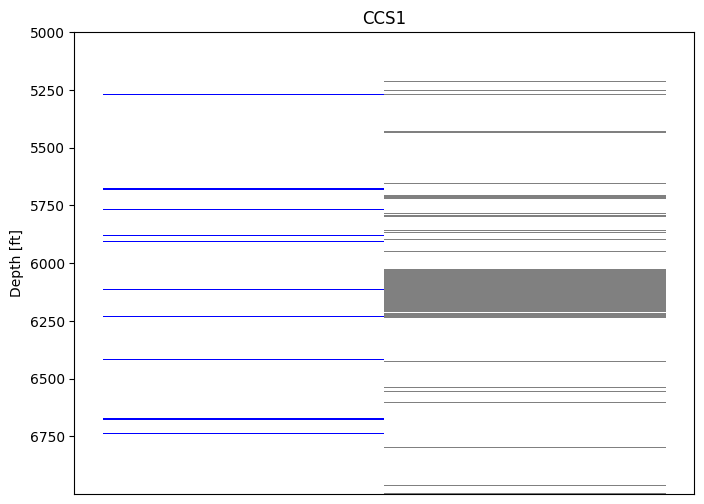


Training on ['CCS1'], testing on VW1
Number of features considered: 29

Results for training:
Average accuracy is 75.18%
Average precision is 68.42%
Average recall is 48.42%
Average f1 is 56.31%

 Predicted 1684 fractures but there were 569

Results for testing:
Average accuracy is 61.72%
Average precision is 21.44%
Average recall is 63.44%
Average f1 is 32.05%


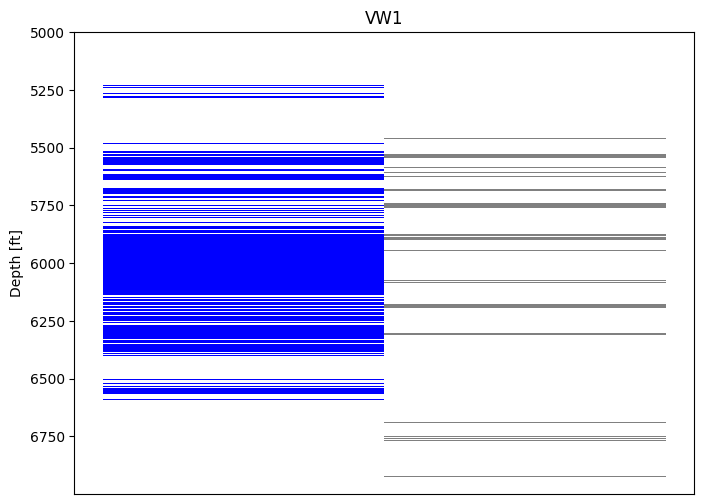

In [ ]:
for i in range(len(WELLS)):
  ### iterate through which well is used for testing (rest used for training)
  curr_well = WELLS[i]
  print(f"\nTraining on {[well for well in WELLS if well != curr_well]},\
          testing on {curr_well}")
  testset = datasets[curr_well]
  trainsets = [datasets[well] for well in WELLS if well != curr_well]
  trainset = pd.concat(trainsets)
  depths = testset["DEPT"]

  ### optional undersampling of majority class
  #trainset = balance_dataset(trainset)

  X_train = np.array(trainset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_train = np.array(trainset["HAS_FRAC"])
  X_test = np.array(testset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_test = np.array(testset["HAS_FRAC"])

  ### optional data preprocessing steps
  X_train, X_test = normalize(X_train, X_test)
  #X_train, X_test = apply_PCA(X_train, X_test)

  ### train/test model and plot results
  train_model(X_train, y_train)
  y_pred = test_model(X_test, y_test)
  plot_depths_with_labels(curr_well, depths, y_pred, y_test)